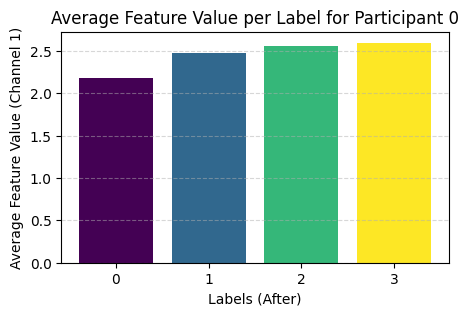

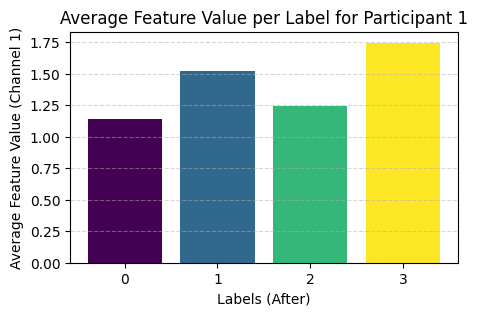

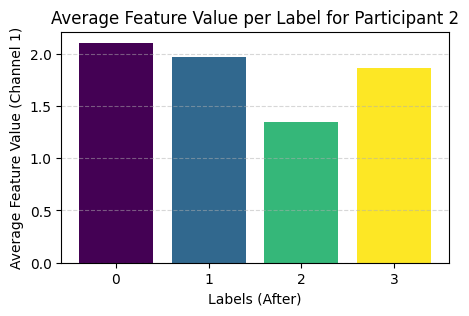

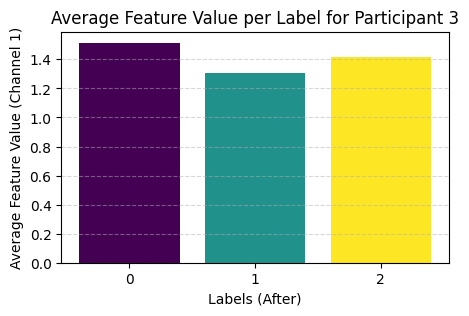

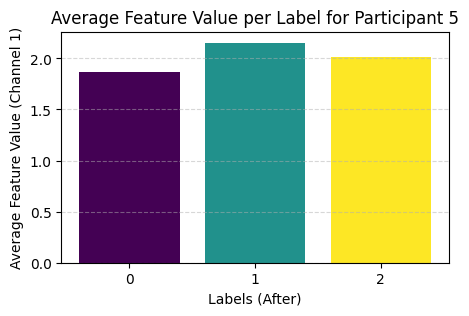

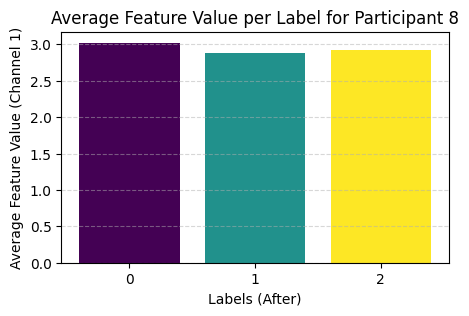

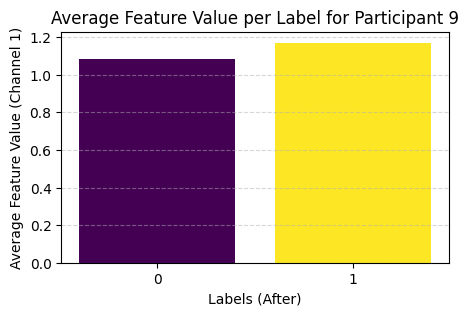

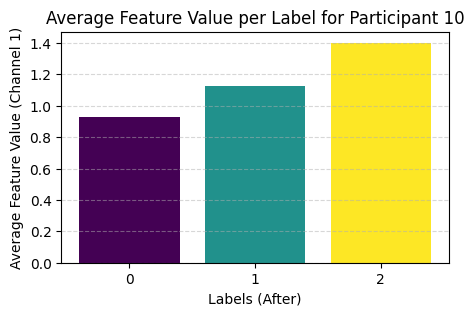

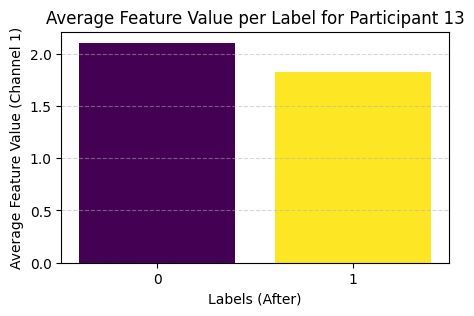

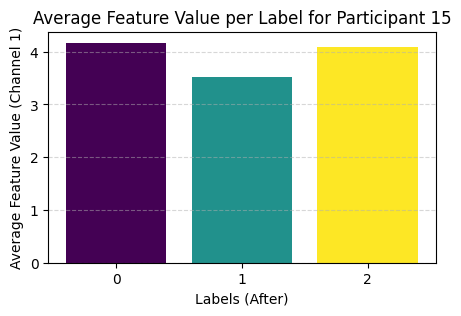

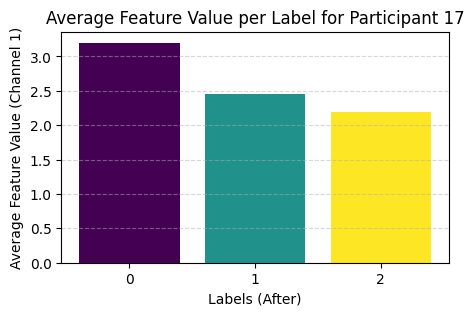

In [2]:
import os
import scipy.io as sio
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from MFDFA import MFDFA

import warnings
warnings.filterwarnings('ignore')

class MatFileDataset(Dataset):
    def __init__(self, directory, fdindex, feature_selection='DHE'):
        self.participant_data = {}
        self.FDIndex = fdindex
        self.num_channels = 4
        self.feature_selection = feature_selection  # Feature selection string (D, H, E)
        self._load_data(directory)
        self._filter_non_fatigue_participants()
        

    def _load_data(self, directory):
        mat_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".mat")]
        if len(mat_files) != self.num_channels:
            raise ValueError(f"Expected {self.num_channels} .mat files, found {len(mat_files)}")

        all_data = [sio.loadmat(f, struct_as_record=False, squeeze_me=True) for f in mat_files]
        num_participants = len(all_data[0]["all_window_features"])

        for idx in range(num_participants):
            windows = [data["all_window_features"][idx] for data in all_data]
            if any(p is None for p in windows):
                continue
            self._extract_features(idx, windows)

    def _extract_features(self, idx, windows):
        features, signals, labels, dq_values, hq_values, emergence_values = [], [], [], [], [], []
        for win_data in zip(*windows):
            before, after = getattr(win_data[0], "before_label", None), getattr(win_data[0], "after_label", None)
            if None in (before, after) or not (0 <= before <= 3 and 0 <= after <= 3):
                continue

            fractals, sigs, dqs, hqs, emergences = [], [], [], [], []
            for window in win_data:
                signal = self._get_signal(window)
                if signal.numel() != 1:
                    sigs.append(signal)
                dq = self._get_cleaned_dq(window) if 'D' in self.feature_selection else None
                hq = self._get_cleaned_hq(window) if 'H' in self.feature_selection else None
                emergence = self._calculate_emergence(dq, window) if 'E' in self.feature_selection else None
                # self._calculated_dfa(signal=signal)

                if ((dq is not None) or (hq is not None) or (emergence is not None)):                    
                    dqs.append(dq)
                    hqs.append(hq)
                    emergences.append(emergence)

                    feature_components = []
                    if 'D' in self.feature_selection and dq is not None:
                        # feature_components.append(torch.tensor(dq, dtype=torch.float32).unsqueeze(1))
                        feature_components.append(torch.tensor(dq[self.FDIndex], dtype=torch.float32).unsqueeze(0))  # 
                    if 'H' in self.feature_selection and hq is not None:
                        # feature_components.append(torch.tensor(hq, dtype=torch.float32).unsqueeze(1))
                        feature_components.append(torch.tensor(hq[self.FDIndex], dtype=torch.float32).unsqueeze(0))  #
                    if 'E' in self.feature_selection and emergence is not None:
                        emergence_tensor = torch.tensor([emergence], dtype=torch.float32).expand_as(torch.tensor(dq, dtype=torch.float32).unsqueeze(1))
                        feature_components.append(emergence_tensor)
                        
                    # combined_features = torch.cat(feature_components, dim=1).repeat(1, 41)
                    combined_features = torch.cat(feature_components, dim=0)

                    fractals.append(combined_features)

            if fractals:
                features.append(torch.stack(fractals))
                if sigs:
                    signals.append(torch.stack(sigs))
                labels.append((before, after))
                dq_values.append(dqs)
                hq_values.append(hqs)
                emergence_values.append(emergences)

        if features:
            self.participant_data[idx] = {
                'features': features,
                'signals': signals,
                'labels': labels,
                'dq_values': dq_values,
                'hq_values': hq_values,
                'emergence_values': np.concatenate(emergence_values) if emergence_values else []
            }

    def _get_signal(self, window):
        return torch.tensor(window.raw_window_signal.flatten(), dtype=torch.float32) if hasattr(window, "raw_window_signal") else torch.zeros(1)

    def _get_cleaned_dq(self, window):
        if hasattr(window, "Dq") and window.Dq is not None:
            dq = np.array(window.Dq, dtype=np.float32)
            if dq.size > 0:
                dq[np.isnan(dq)] = np.nanmin(dq[np.isfinite(dq)])
                dq[np.isinf(dq)] = np.nanmax(dq[np.isfinite(dq)])
                return dq
        return None

    def _get_cleaned_hq(self, window):
        if hasattr(window, "hq") and window.hq is not None:
            hq = np.array(window.hq, dtype=np.float32)
            if hq.size > 0:
                hq[np.isnan(hq)] = np.nanmin(hq[np.isfinite(hq)])
                hq[np.isinf(hq)] = np.nanmax(hq[np.isfinite(hq)])
                return hq
        return None

    def _calculate_emergence(self, dq, window):
        if dq is None or not hasattr(window, "q") or window.q is None or not hasattr(window, "raw_window_signal"):
            return None
        q = np.array(window.q, dtype=np.float32).flatten()
        dq = dq.flatten()
        t = np.arange(len(window.raw_window_signal))
        alpha_q = np.gradient((q - 1) * dq, q)
        g_q = np.gradient(alpha_q, q)
        t_interp = np.linspace(t.min(), t.max(), len(dq)) if len(dq) != len(t) else t
        dq_t = np.interp(t_interp, t[:len(dq)], np.gradient(dq, t[:len(dq)])) if len(dq) != len(t) else np.gradient(dq, t)
        return np.trapz(dq_t * g_q, q)
    
    def _calculated_dfa(self,signal):
        lag = np.unique(np.logspace(0.5, 3, 100).astype(int))
        q_list = np.linspace(-10, 10, 41)
        q_list = q_list[q_list != 0.0]
        lag, dfa = MFDFA(signal.flatten().numpy(), lag=lag, q=q_list, order=1)
        slopes_sun = np.polynomial.polynomial.polyfit(np.log(lag)[20:55], np.log(dfa)[20:55], 1)[1] 
        t_sun = q_list * slopes_sun - 1
        hq_sun = np.gradient(t_sun) / np.gradient(q_list)
        f_sun = q_list * hq_sun - t_sun
        plt.plot(hq_sun[5:20], f_sun[5:20],'o', markersize=9, markerfacecolor='none')
        plt.plot(hq_sun[20:], f_sun[20:],'o', markersize=9,markerfacecolor='none')
        plt.show()



    def _filter_non_fatigue_participants(self):
        self.participant_data = {idx: data for idx, data in self.participant_data.items() if any(lbl[1] != 0 for lbl in data['labels'])}

    def __len__(self):
        return sum(len(data['features']) for data in self.participant_data.values())

    def __getitem__(self, idx):
        participant_idx, sample_idx = divmod(idx, len(self.participant_data))
        data = self.participant_data[participant_idx]
        return {
            'fractal': data['features'][sample_idx],
            'signal': data['signals'][sample_idx]
        }, {
            "before_label": torch.tensor(data['labels'][sample_idx][0], dtype=torch.long),
            "after_label": torch.tensor(data['labls'][sample_idx][1], dtype=torch.long)
        }

dataset = MatFileDataset("/Users/athenasaghi/VSProjects/CognitiveFatigueDetection/Prediction/window50/", 12 ,feature_selection='H')

participant_feature_values = {
    idx: {
        "features": np.array([feature[2].numpy() for feature in data['features']]),  # Extract raw feature values
        "labels": np.array([label[1] for label in data['labels']])  # Extract after_label (assumed window label)
    }
    for idx, data in dataset.participant_data.items()
}

for idx, participant_data in participant_feature_values.items():
    features = participant_data["features"]  # Feature values
    labels = participant_data["labels"]  # Labels

    unique_labels = np.unique(labels)
    avg_feature_values = [np.mean(features[labels == label]) for label in unique_labels]  # Average per label

    plt.figure(figsize=(5, 3))
    plt.bar(unique_labels, avg_feature_values, color=plt.cm.viridis(np.linspace(0, 1, len(unique_labels))))
    
    plt.xlabel('Labels (After)')
    plt.ylabel('Average Feature Value (Channel 1)')
    plt.title(f'Average Feature Value per Label for Participant {idx}')
    plt.xticks(unique_labels)  # Ensure all labels are shown

    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()


# Dq in q = 12

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

dataset = MatFileDataset("/Users/athenasaghi/VSProjects/CognitiveFatigueDetection/Prediction/window50/", feature_selection='H' , fdindex=2)


all_features = []
all_labels = []
participants = list(dataset.participant_data.keys())

for idx, data in dataset.participant_data.items():
    features = np.array([np.array([feature[ch].numpy() for ch in range(4)]) for feature in data['features']])  # Ensure (num_windows, 4)
    labels = np.array([label[1] for label in data['labels']])  # After-labels as target    
    labels = np.where(labels <= 1, 0, 1)
    all_features.append(features)
    all_labels.append(labels)

all_features = np.vstack(all_features).reshape(-1, 4)  # Ensure (total_windows, 4)
all_labels = np.concatenate(all_labels).flatten()  # Ensure (total_windows,)

X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=0.2, random_state=42, stratify=all_labels)


smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Train Teacher Model
rf = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42)
rf.fit(X_train, y_train)
rf_test_predictions = rf.predict(X_test)

# Train Student Model on Training Set
teacher_train_predictions = rf.predict_proba(X_train)  # Soft labels
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')


knn.fit(X_train, teacher_train_predictions.argmax(axis=1))
knn_test_predictions = knn.predict(X_test)

# Evaluate on Test Set
print("Random Forest Test Classification Report:")
print(classification_report(y_test, rf_test_predictions))

print("KNN Test Classification Report:")
print(classification_report(y_test, knn_test_predictions))



Random Forest Test Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.68      0.73      2651
           1       0.27      0.40      0.32       781

    accuracy                           0.61      3432
   macro avg       0.53      0.54      0.53      3432
weighted avg       0.67      0.61      0.64      3432

KNN Test Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.61      0.69      2651
           1       0.25      0.45      0.32       781

    accuracy                           0.57      3432
   macro avg       0.52      0.53      0.51      3432
weighted avg       0.67      0.57      0.61      3432



Participant 0 - Feature Shape: (1541, 4)


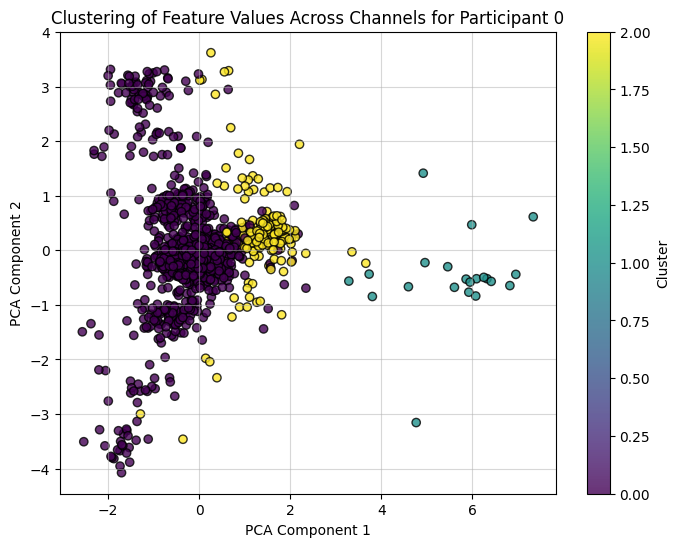

Participant 1 - Feature Shape: (1219, 4)


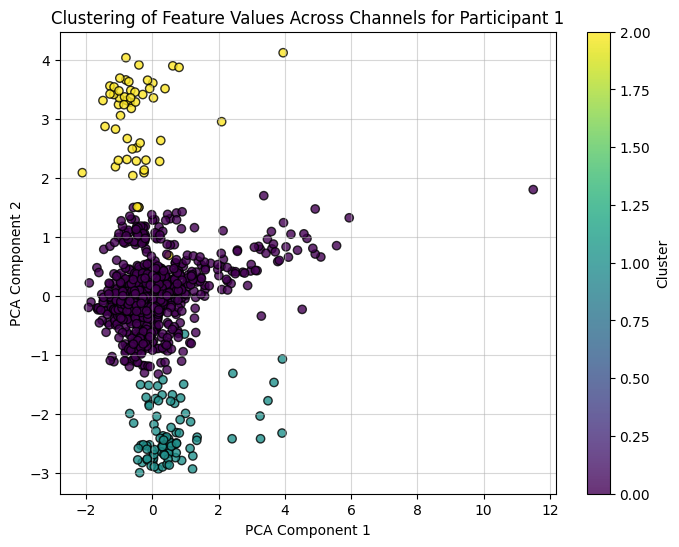

Participant 2 - Feature Shape: (956, 4)


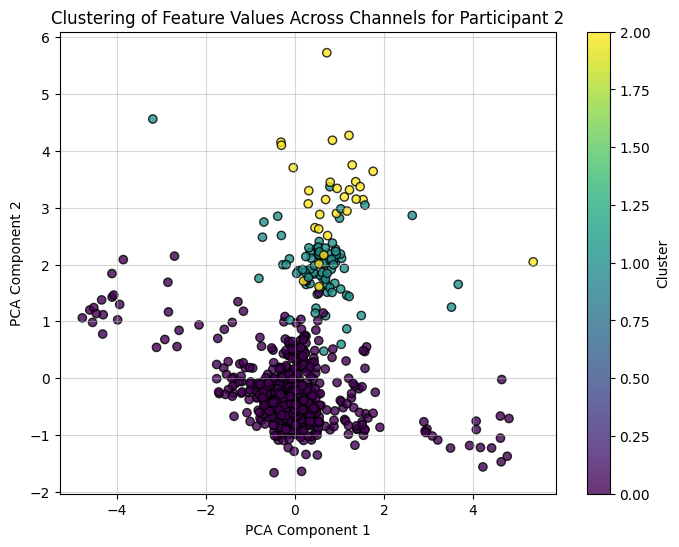

Participant 3 - Feature Shape: (1613, 4)


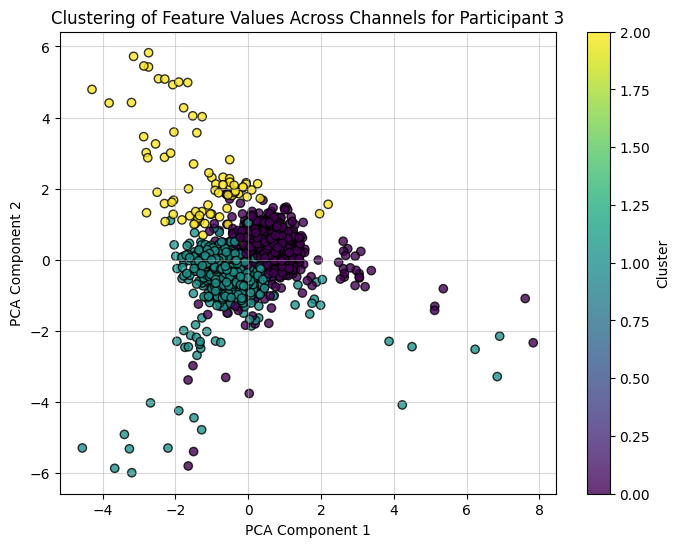

Participant 5 - Feature Shape: (1600, 4)


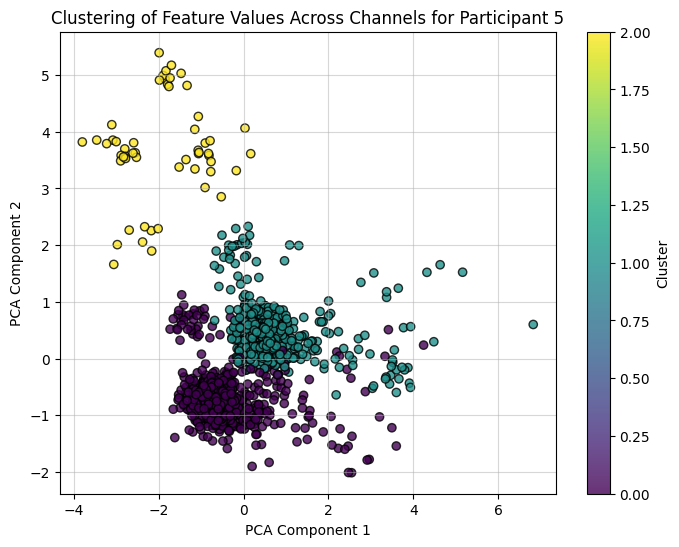

Participant 8 - Feature Shape: (1742, 4)


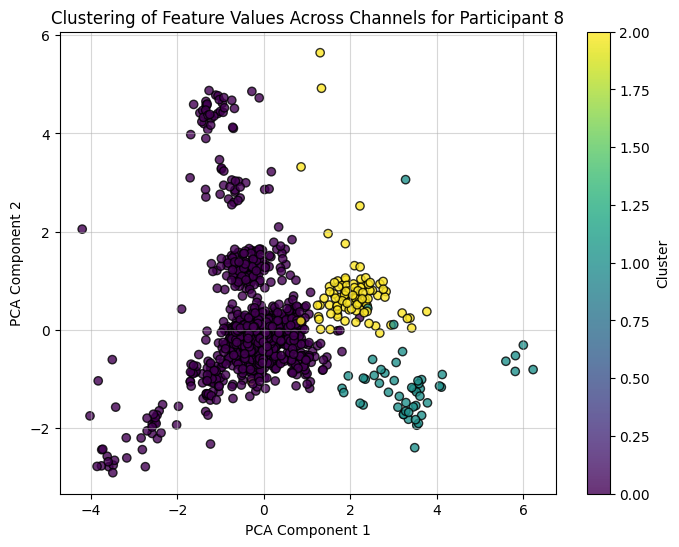

Participant 9 - Feature Shape: (1794, 4)


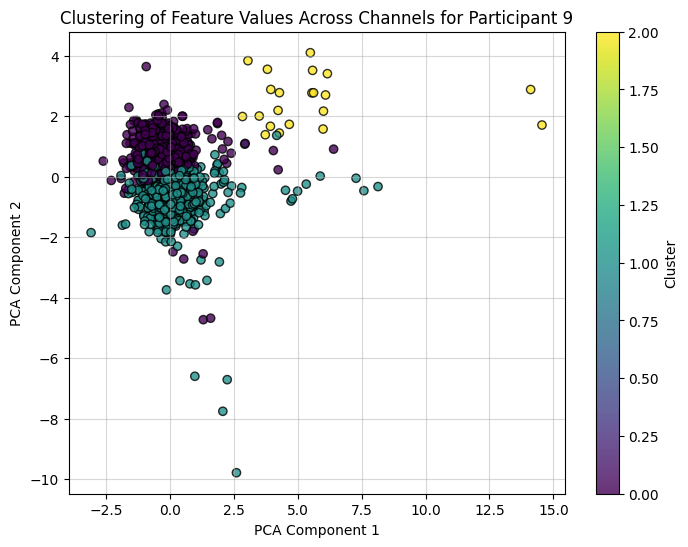

Participant 10 - Feature Shape: (1658, 4)


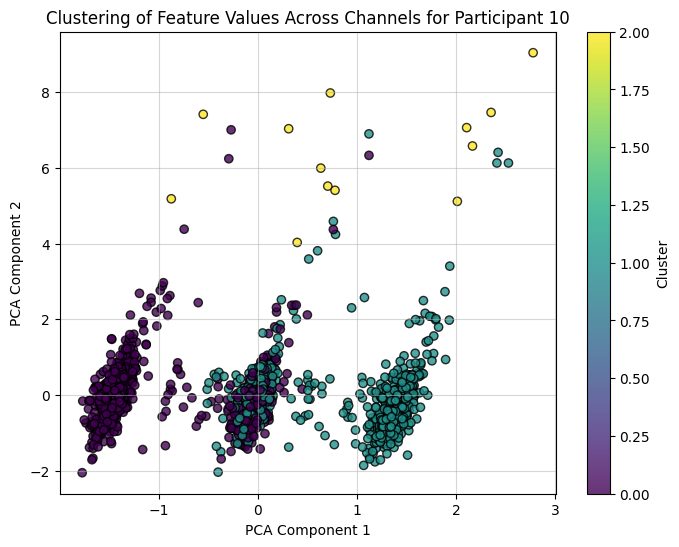

Participant 13 - Feature Shape: (1821, 4)


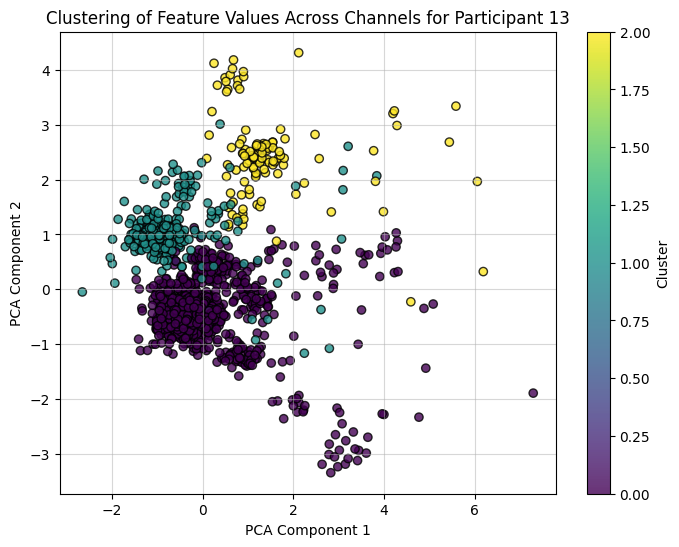

Participant 15 - Feature Shape: (1389, 4)


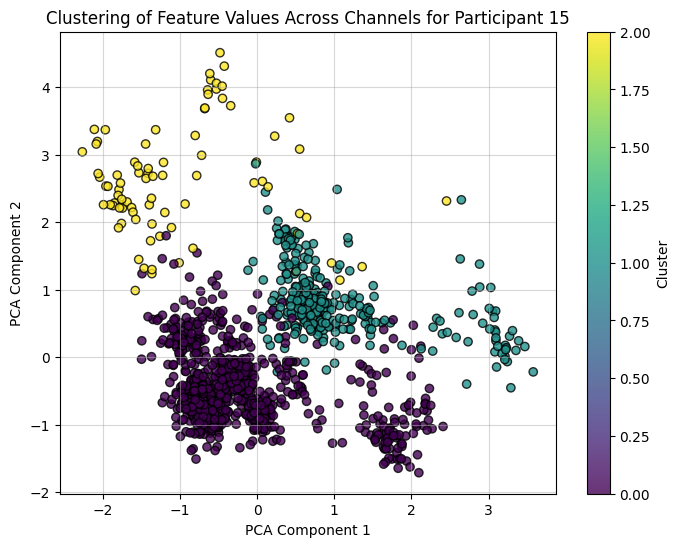

Participant 17 - Feature Shape: (1826, 4)


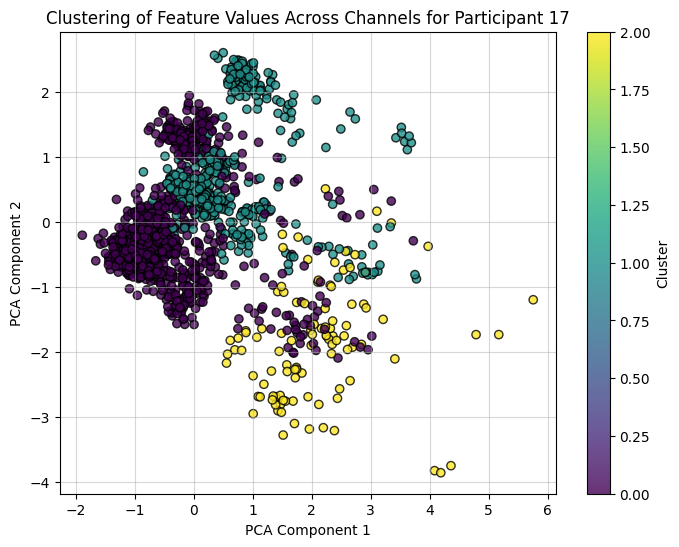

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Collect feature values for all four brain channels
participant_feature_values = {
    idx: {
        "features": np.array([np.array([feature[ch].numpy() for ch in range(4)]) for feature in data['features']]),  # Extract all 4 channel values
        "labels": np.array([label[1] for label in data['labels']])  # Extract after_label (assumed window label)
    }
    for idx, data in dataset.participant_data.items()
}

# Perform clustering and visualization for each participant
for idx, participant_data in participant_feature_values.items():
    features = np.squeeze(participant_data["features"])  # Ensure features is 2D: (num_windows, 4)
    labels = participant_data["labels"]  # Labels for reference

    # Verify shape
    print(f"Participant {idx} - Feature Shape: {features.shape}")  # Should be (num_windows, 4)

    # Normalize features
    features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)

    # Perform K-Means clustering (choosing 3 clusters)
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(features)  # KMeans expects (num_samples, num_features)

    # Reduce dimensions to 2D using PCA for visualization
    pca = PCA(n_components=3)
    reduced_features = pca.fit_transform(features)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis', edgecolors='black', alpha=0.8)
    
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'Clustering of Feature Values Across Channels for Participant {idx}')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(alpha=0.5)

    plt.show()


In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import f_oneway

# Collect all participants' data into a single dataset
all_features = []
all_labels = []

for idx, data in dataset.participant_data.items():
    features = np.array([np.array([feature[ch].numpy() for ch in range(4)]) for feature in data['features']])  # Ensure (num_windows, 4)
    labels = np.array([label[1] for label in data['labels']])  # After-labels as target

    all_features.append(features)
    all_labels.append(labels)

# Convert lists to numpy arrays
all_features = np.vstack(all_features).reshape(-1, 4)  # Ensure (total_windows, 4)
all_labels = np.concatenate(all_labels).flatten()  # Ensure (total_windows,)


anova_results = []
for i in range(all_features.shape[1]):  # Loop over PCA components
    class_values = [all_features[all_labels == label, i] for label in np.unique(all_labels)]
    f_stat, p_value = f_oneway(*class_values)
    anova_results.append((f_stat, p_value))
    print(f"ANOVA for PCA Component {i+1}: F-stat={f_stat:.4f}, p-value={p_value:.45f}")


ANOVA for PCA Component 1: F-stat=24.2603, p-value=0.000000000000001167306550375281899164224102225
ANOVA for PCA Component 2: F-stat=14.9722, p-value=0.000000000991204098698976328878678004918097860
ANOVA for PCA Component 3: F-stat=19.8145, p-value=0.000000000000812257010255791351881834964931071
ANOVA for PCA Component 4: F-stat=94.5752, p-value=0.000000000000000000000000000000000000000000000


In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from itertools import combinations

# Collect all participants' data into a single dataset
all_features = []
all_labels = []
participants = list(dataset.participant_data.keys())

for idx, data in dataset.participant_data.items():
    features = np.array([np.array([feature[ch].numpy() for ch in range(4)]) for feature in data['features']])  # Ensure (num_windows, 4)
    labels = np.array([label[1] for label in data['labels']])  # After-labels as target

    all_features.append(features)
    all_labels.append(labels)

# Convert lists to numpy arrays
all_features = np.vstack(all_features).reshape(-1, 4)  # Ensure (total_windows, 4)
all_labels = np.concatenate(all_labels).flatten()  # Ensure (total_windows,)

# Standardize features
scaler = StandardScaler()
all_features = scaler.fit_transform(all_features)

# Train Teacher Model (Random Forest)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(all_features, all_labels)
teacher_predictions = rf.predict_proba(all_features)  # Soft labels

# Train Student Model (KNN) using soft labels
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(all_features, teacher_predictions.argmax(axis=1))
student_predictions = knn.predict(all_features)

# Evaluate both models
rf_accuracy = accuracy_score(all_labels, rf.predict(all_features))
knn_accuracy = accuracy_score(all_labels, student_predictions)

print(f"Random Forest (Teacher) Accuracy: {rf_accuracy:.2f}")
print(f"KNN (Student) Accuracy: {knn_accuracy:.2f}")
print("Teacher Model Classification Report:")
print(classification_report(all_labels, rf.predict(all_features)))
print("Student Model Classification Report:")
print(classification_report(all_labels, student_predictions))


Random Forest (Teacher) Accuracy: 1.00
KNN (Student) Accuracy: 0.57
Teacher Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6516
           1       1.00      1.00      1.00      6740
           2       1.00      1.00      1.00      3101
           3       1.00      1.00      1.00       802

    accuracy                           1.00     17159
   macro avg       1.00      1.00      1.00     17159
weighted avg       1.00      1.00      1.00     17159

Student Model Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.75      0.63      6516
           1       0.61      0.63      0.62      6740
           2       0.60      0.21      0.31      3101
           3       0.53      0.07      0.13       802

    accuracy                           0.57     17159
   macro avg       0.57      0.42      0.42     17159
weighted avg       0.58      0.57      0.54

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from itertools import combinations

# Collect all participants' data into a single dataset
all_features = []
all_labels = []
participants = list(dataset.participant_data.keys())

for idx, data in dataset.participant_data.items():
    features = np.array([np.array([feature[ch].numpy() for ch in range(4)]) for feature in data['features']])  # Ensure (num_windows, 4)
    labels = np.array([label[1] for label in data['labels']])  # After-labels as target
    
    # Merge labels: 0 and 1 -> 0, 2 and 3 -> 1
    labels = np.where(labels <= 1, 0, 1)
    
    all_features.append(features)
    all_labels.append(labels)

# Convert lists to numpy arrays
all_features = np.vstack(all_features).reshape(-1, 4)  # Ensure (total_windows, 4)
all_labels = np.concatenate(all_labels).flatten()  # Ensure (total_windows,)

# Standardize features
scaler = StandardScaler()
all_features = scaler.fit_transform(all_features)

# Train Teacher Model (Random Forest)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(all_features, all_labels)
teacher_predictions = rf.predict_proba(all_features)  # Soft labels

# Train Student Model (KNN) using soft labels
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(all_features, teacher_predictions.argmax(axis=1))
student_predictions = knn.predict(all_features)

# Evaluate both models
rf_accuracy = accuracy_score(all_labels, rf.predict(all_features))
knn_accuracy = accuracy_score(all_labels, student_predictions)

print(f"Random Forest (Teacher) Accuracy: {rf_accuracy:.2f}")
print(f"KNN (Student) Accuracy: {knn_accuracy:.2f}")
print("Teacher Model Classification Report:")
print(classification_report(all_labels, rf.predict(all_features)))
print("Student Model Classification Report:")
print(classification_report(all_labels, student_predictions))


Random Forest (Teacher) Accuracy: 1.00
KNN (Student) Accuracy: 0.80
Teacher Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13256
           1       1.00      1.00      1.00      3903

    accuracy                           1.00     17159
   macro avg       1.00      1.00      1.00     17159
weighted avg       1.00      1.00      1.00     17159

Student Model Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88     13256
           1       0.64      0.25      0.36      3903

    accuracy                           0.80     17159
   macro avg       0.73      0.61      0.62     17159
weighted avg       0.77      0.80      0.76     17159



In [14]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from itertools import combinations

# Collect all participants' data into a single dataset
all_features = []
all_labels = []
participants = list(dataset.participant_data.keys())

for idx, data in dataset.participant_data.items():
    features = np.array([np.array([feature[ch].numpy() for ch in range(4)]) for feature in data['features']])  # Ensure (num_windows, 4)
    labels = np.array([label[1] for label in data['labels']])  # After-labels as target
    
    # Merge labels: 0 and 1 -> 0, 2 and 3 -> 1
    labels = np.where(labels <= 1, 0, 1)
    
    all_features.append(features)
    all_labels.append(labels)

# Convert lists to numpy arrays
all_features = np.vstack(all_features).reshape(-1, 4)  # Ensure (total_windows, 4)
all_labels = np.concatenate(all_labels).flatten()  # Ensure (total_windows,)

# Standardize features
scaler = StandardScaler()
all_features = scaler.fit_transform(all_features)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
all_features, all_labels = smote.fit_resample(all_features, all_labels)

# Train Teacher Model (Random Forest) with optimized hyperparameters
rf = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42)
rf.fit(all_features, all_labels)
teacher_predictions = rf.predict_proba(all_features)  # Soft labels

# Train Student Model (KNN) using soft labels
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(all_features, teacher_predictions.argmax(axis=1))
student_predictions = knn.predict(all_features)

# Evaluate both models
rf_accuracy = accuracy_score(all_labels, rf.predict(all_features))
knn_accuracy = accuracy_score(all_labels, student_predictions)

print(f"Random Forest (Teacher) Accuracy: {rf_accuracy:.2f}")
print(f"KNN (Student) Accuracy: {knn_accuracy:.2f}")
print("Teacher Model Classification Report:")
print(classification_report(all_labels, rf.predict(all_features)))
print("Student Model Classification Report:")
print(classification_report(all_labels, student_predictions))


Random Forest (Teacher) Accuracy: 0.96
KNN (Student) Accuracy: 0.96
Teacher Model Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     13256
           1       0.93      0.99      0.96     13256

    accuracy                           0.96     26512
   macro avg       0.96      0.96      0.96     26512
weighted avg       0.96      0.96      0.96     26512

Student Model Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     13256
           1       0.93      0.99      0.96     13256

    accuracy                           0.96     26512
   macro avg       0.96      0.96      0.96     26512
weighted avg       0.96      0.96      0.96     26512



In [70]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import collections

# Collect all participants' data into a single dataset
all_features = []
all_labels = []
participants = list(dataset.participant_data.keys())

for idx, data in dataset.participant_data.items():
    features = np.array([np.array([feature[ch].numpy() for ch in range(4)]) for feature in data['features']])  # Ensure (num_windows, 4)
    labels = np.array([label[1] for label in data['labels']])  # After-labels as target

    # Merge labels: 0 and 1 -> 0, 2 and 3 -> 1
    labels = np.where(labels <= 1, 0, 1)
    
    all_features.append(features)
    all_labels.append(labels)

# Convert lists to numpy arrays
all_features = np.vstack(all_features).reshape(-1, 4)  # Ensure (total_windows, 4)
all_labels = np.concatenate(all_labels).flatten()  # Ensure (total_windows,)

# Print label distribution before SMOTE
print("Label distribution before SMOTE:", collections.Counter(all_labels))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE to balance the dataset only on the training set
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Print label distribution after SMOTE
print("Label distribution after SMOTE:", collections.Counter(y_train))

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Ensure float for BCE loss
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

# Define Transformer-Based Attention Model
class TransformerAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads):
        super(TransformerAttentionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.positional_encoding = PositionalEncoding(hidden_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(hidden_dim, 1)  # Single neuron output for binary classification

    def forward(self, x):
        h = torch.relu(self.fc1(x)).unsqueeze(1)  # Hidden representation
        h = self.positional_encoding(h)
        attn_output, _ = self.multihead_attn(h, h, h)
        attn_output = self.layer_norm(attn_output + h)
        attn_output = self.dropout(attn_output.squeeze(1))
        out = self.fc2(attn_output).squeeze(1)  # Output logits (no sigmoid here)
        return out

# Initialize model, loss function, and optimizer
input_dim = X_train.shape[1]
model = TransformerAttentionModel(input_dim=input_dim, hidden_dim=64, num_heads=2)
criterion = nn.BCEWithLogitsLoss()  # Corrected loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train function
def train(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze(1)  # Get logits
            y_batch = y_batch.to(outputs.device)  # Ensure target is on the same device
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluate function
def evaluate(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch).squeeze(1)  # Get raw logits
            probabilities = torch.sigmoid(outputs)  # Convert logits to probabilities
            binary_predictions = (probabilities >= 0.5).cpu().numpy().astype(int)  # Apply threshold

            y_true.extend(y_batch.numpy())
            y_pred.extend(binary_predictions)

    print("Transformer Attention Model Test Classification Report:")
    print(classification_report(y_true, y_pred))

# Run training and evaluation
train(model, train_loader, criterion, optimizer, epochs=20)
evaluate(model, test_loader)


Label distribution before SMOTE: Counter({0: 13256, 1: 3903})
Label distribution after SMOTE: Counter({0: 10605, 1: 5302})


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
# import torch.nn as nn
# import torch.optim as optim
# from torchvision.models.video import r3d_18
# import numpy as np
# import torch.nn.functional as F
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_auc_score
# from torch.utils.data import DataLoader, random_split
# from imblearn.over_sampling import SMOTE
# from sklearn.impute import SimpleImputer


# # Define ResNet-18 3D Model for Your Data
# class Predefined3DResNet(nn.Module):
#     def __init__(self, num_channels=4, num_classes=4):
#         super(Predefined3DResNet, self).__init__()
#         self.model = r3d_18(pretrained=False)  # Load ResNet-18 3D model
#         self.model.stem[0] = nn.Conv3d(num_channels, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)  # Modify input layer
#         self.model.fc = nn.Sequential(
#             nn.BatchNorm1d(512),
#             nn.Dropout(0.6),  # Increased from 0.5 to 0.6
#             nn.Linear(512, num_classes)
# )


#     def forward(self, x):
#         return self.model(x)




# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # Initialize Model, Loss, and Optimizer
# model = Predefined3DResNet(num_channels=4, num_classes=4).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001 , weight_decay=1e-4)


# # Dataset Split: 70% Train, 15% Validation, 15% Test
# train_size = int(0.4 * len(dataset))
# val_size = int(0.2 * len(dataset))
# test_size = len(dataset) - train_size - val_size
# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


# # Convert dataset to numpy for SMOTE
# X_train, y_train, X_val, y_val, X_test ,y_test = [], [], [], [],[],[]
# for i in range(len(train_dataset)):
#     x, y = train_dataset[i]
#     X_train.append(x['fractal'].numpy().flatten())
#     y_train.append(y["before_label"].item())
# for i in range(len(val_dataset)):
#     x, y = val_dataset[i]
#     X_val.append(x['fractal'].numpy().flatten())
#     y_val.append(y["before_label"].item())
# for i in range(len(test_dataset)):
#     x, y = test_dataset[i]
#     X_test.append(x['fractal'].numpy().flatten())
#     y_test.append(y["before_label"].item())
# X_train, y_train = np.array(X_train), np.array(y_train)
# X_val, y_val = np.array(X_val), np.array(y_val)
# X_test,y_test = np.array(X_test),np.array(y_test)

# imputer = SimpleImputer(strategy='mean')
# X_train = imputer.fit_transform(np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0))
# X_val = imputer.fit_transform(np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0))
# X_test = imputer.fit_transform(np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0))

# #### over sampling 
# smote = SMOTE(k_neighbors=min(5, np.min(np.bincount(y_train))-1))
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# smote_val = SMOTE(k_neighbors=min(5, np.min(np.bincount(y_val))-1))
# X_val_resampled, y_val_resampled = smote_val.fit_resample(X_val, y_val)

# # Convert back to tensor dataset
# X_train_resampled = torch.tensor(X_train_resampled.reshape(-1, 4, 41, 41, 3), dtype=torch.float32)
# y_train_resampled = torch.tensor(y_train_resampled, dtype=torch.long)
# X_val_resampled = torch.tensor(X_val_resampled.reshape(-1, 4, 41, 41, 3), dtype=torch.float32)
# y_val_resampled = torch.tensor(y_val_resampled, dtype=torch.long)

# balanced_train_dataset = torch.utils.data.TensorDataset(X_train_resampled, y_train_resampled)
# balanced_val_dataset = torch.utils.data.TensorDataset(X_val_resampled, y_val_resampled)

# # Create DataLoaders
# train_loader = DataLoader(balanced_train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(balanced_val_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# # Training Function with Validation
# def train_model(train_loader, val_loader, model, optimizer, criterion, num_epochs=50):
#     model.train()
#     best_val_loss = float("inf")

#     # Lists to store metrics
#     train_losses, train_accuracies, train_aucs = [], [], []
#     val_losses, val_accuracies, val_aucs = [], [], []

#     for epoch in range(num_epochs):
#         running_loss, correct, total = 0.0, 0, 0
#         all_labels, all_probs = [], []

#         # Training Loop
#         for batch in train_loader:
#             x, y = batch
#             fractal_features = x.to(device)
            
#             # Check for NaN/Inf values and skip batch if found
#             if torch.isnan(fractal_features).any() or torch.isinf(fractal_features).any():
#                 continue

#             labels = y.to(device)

#             optimizer.zero_grad()
#             outputs = model(fractal_features)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             running_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             correct += (predicted == labels).sum().item()
#             total += labels.size(0)

#             # Store outputs for AUC computation
#             all_labels.extend(labels.cpu().numpy())
#             all_probs.extend(F.softmax(outputs, dim=1).cpu().detach().numpy())

#         # Compute train metrics
#         train_loss = running_loss / len(train_loader)
#         train_accuracy = 100 * correct / total
#         train_losses.append(train_loss)
#         train_accuracies.append(train_accuracy)

#         # Compute Train AUC
#         train_auc = roc_auc_score(np.array(all_labels), np.array(all_probs), multi_class='ovr')
      
#         train_aucs.append(train_auc)

#         # =====================
#         # Validation Loop
#         # =====================
#         model.eval()
#         val_loss, val_correct, val_total = 0.0, 0, 0
#         val_labels, val_probs = [], []

#         with torch.no_grad():
#             for batch in val_loader:
#                 x, y = batch
#                 fractal_features = x.to(device)
#                 labels = y.to(device)
#                 if torch.isnan(fractal_features).any() or torch.isinf(fractal_features).any():
#                     continue
#                 outputs = model(fractal_features)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item()
#                 _, predicted = torch.max(outputs, 1)
#                 val_correct += (predicted == labels).sum().item()
#                 val_total += labels.size(0)

#                 val_labels.extend(labels.cpu().numpy())
#                 val_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())

        
#         # Compute validation metrics
#         val_loss /= len(val_loader)
#         val_accuracy = 100 * val_correct / val_total
#         val_losses.append(val_loss)
#         val_accuracies.append(val_accuracy)
  
#         # Compute Validation AUC
#         val_auc = roc_auc_score(np.array(val_labels), np.array(val_probs), multi_class='ovr')
     
#         val_aucs.append(val_auc)

#         print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Train AUC: {train_auc:.4f} | "
#               f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, Val AUC: {val_auc:.4f}")

#         model.train()  # Switch back to training mode

#     # Plot Training and Validation Metrics
#     # plot_training_metrics(train_losses, train_accuracies, train_aucs, val_losses, val_accuracies, val_aucs)

# # Function to Plot Training and Validation Metrics
# def plot_training_metrics(train_losses, train_accuracies, train_aucs, val_losses, val_accuracies, val_aucs):
#     epochs = range(1, len(train_losses) + 1)
    
#     plt.figure(figsize=(12, 4))

#     # Loss Plot
#     plt.subplot(1, 3, 1)
#     plt.plot(epochs, train_losses, marker='o', label="Train Loss")
#     plt.plot(epochs, val_losses, marker='o', linestyle='dashed', label="Val Loss")
#     plt.xlabel("Epochs")
#     plt.ylabel("Loss")
#     plt.title("Loss over Epochs")
#     plt.legend()

#     # Accuracy Plot
#     plt.subplot(1, 3, 2)
#     plt.plot(epochs, train_accuracies, marker='o', label="Train Accuracy")
#     plt.plot(epochs, val_accuracies, marker='o', linestyle='dashed', label="Val Accuracy")
#     plt.xlabel("Epochs")
#     plt.ylabel("Accuracy (%)")
#     plt.title("Accuracy over Epochs")
#     plt.legend()

#     # AUC Plot
#     plt.subplot(1, 3, 3)
#     plt.plot(epochs, train_aucs, marker='o', label="Train AUC")
#     plt.plot(epochs, val_aucs, marker='o', linestyle='dashed', label="Val AUC")
#     plt.xlabel("Epochs")
#     plt.ylabel("AUC Score")
#     plt.title("AUC over Epochs")
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# # Train the Model with Train & Validation Set
# train_model(train_loader, val_loader, model, optimizer, criterion, num_epochs=50)

# # =====================
# # Test Evaluation
# # =====================
# def evaluate_model(test_loader, model):
#     model.eval()
#     test_loss, correct, total = 0.0, 0, 0
#     all_labels, all_probs = [], []

#     with torch.no_grad():
#         for batch in test_loader:
#             x, y = batch
#             fractal_features = x['fractal'].to(device)
#             labels = y["before_label"].to(device)

#             if torch.isnan(fractal_features).any() or torch.isinf(fractal_features).any():
#                 continue
#             outputs = model(fractal_features)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             correct += (predicted == labels).sum().item()
#             total += labels.size(0)

#             all_labels.extend(labels.cpu().numpy())
#             all_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())

#     test_loss /= len(test_loader)
#     test_accuracy = 100 * correct / total

#     # Compute Test AUC
#     try:
#         test_auc = roc_auc_score(np.array(all_labels), np.array(all_probs), multi_class='ovr')
#     except ValueError:
#         test_auc = float('nan')

#     print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test AUC: {test_auc:.4f}")

# # Evaluate on the Test Set
# evaluate_model(test_loader, model)




Epoch 1/50 | Train Loss: 1.3268, Train Acc: 43.53%, Train AUC: 0.6835 | Val Loss: 6.9764, Val Acc: 25.00%, Val AUC: 0.6169
Epoch 2/50 | Train Loss: 1.1511, Train Acc: 49.76%, Train AUC: 0.7556 | Val Loss: 1.3316, Val Acc: 42.43%, Val AUC: 0.7093
Epoch 3/50 | Train Loss: 1.0489, Train Acc: 53.71%, Train AUC: 0.7897 | Val Loss: 2.9709, Val Acc: 26.57%, Val AUC: 0.6664
Epoch 4/50 | Train Loss: 0.9711, Train Acc: 56.23%, Train AUC: 0.8173 | Val Loss: 1.5487, Val Acc: 31.71%, Val AUC: 0.7014
Epoch 5/50 | Train Loss: 0.9520, Train Acc: 59.62%, Train AUC: 0.8252 | Val Loss: 1.3029, Val Acc: 47.43%, Val AUC: 0.7260
Epoch 6/50 | Train Loss: 0.9291, Train Acc: 59.23%, Train AUC: 0.8263 | Val Loss: 1.6684, Val Acc: 35.57%, Val AUC: 0.6811
Epoch 7/50 | Train Loss: 0.8558, Train Acc: 61.83%, Train AUC: 0.8513 | Val Loss: 1.2124, Val Acc: 47.00%, Val AUC: 0.7504
Epoch 8/50 | Train Loss: 0.7952, Train Acc: 66.40%, Train AUC: 0.8695 | Val Loss: 1.3871, Val Acc: 50.86%, Val AUC: 0.7241
Epoch 9/50 | Tra

KeyboardInterrupt: 

In [ ]:
# import torch.nn as nn
# import torch.optim as optim
# from torchvision.models.video import r3d_18
# import numpy as np
# import torch.nn.functional as F
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_auc_score
# from torch.utils.data import DataLoader, random_split
# from imblearn.over_sampling import SMOTE
# from sklearn.impute import SimpleImputer


# # Define ResNet-18 3D Model for Your Data
# class Predefined3DResNet(nn.Module):
#     def __init__(self, num_channels=4, num_classes=4):
#         super(Predefined3DResNet, self).__init__()
#         self.model = r3d_18(pretrained=False)  # Load ResNet-18 3D model
#         self.model.stem[0] = nn.Conv3d(num_channels, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)  # Modify input layer
#         self.model.fc = nn.Sequential(
#             nn.BatchNorm1d(512),
#             nn.Dropout(0.6),  # Increased from 0.5 to 0.6
#             nn.Linear(512, num_classes)
# )


#     def forward(self, x):
#         return self.model(x)




# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # Initialize Model, Loss, and Optimizer
# model = Predefined3DResNet(num_channels=4, num_classes=4).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001 , weight_decay=1e-4)


# # Dataset Split: 70% Train, 15% Validation, 15% Test
# train_size = int(0.4 * len(dataset))
# val_size = int(0.2 * len(dataset))
# test_size = len(dataset) - train_size - val_size
# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


# # Convert dataset to numpy for SMOTE
# X_train, y_train, X_val, y_val, X_test ,y_test = [], [], [], [],[],[]
# for i in range(len(train_dataset)):
#     x, y = train_dataset[i]
#     X_train.append(x['fractal'].numpy().flatten())
#     y_train.append(y["before_label"].item())
# for i in range(len(val_dataset)):
#     x, y = val_dataset[i]
#     X_val.append(x['fractal'].numpy().flatten())
#     y_val.append(y["before_label"].item())
# for i in range(len(test_dataset)):
#     x, y = test_dataset[i]
#     X_test.append(x['fractal'].numpy().flatten())
#     y_test.append(y["before_label"].item())
# X_train, y_train = np.array(X_train), np.array(y_train)
# X_val, y_val = np.array(X_val), np.array(y_val)
# X_test,y_test = np.array(X_test),np.array(y_test)

# imputer = SimpleImputer(strategy='mean')
# X_train = imputer.fit_transform(np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0))
# X_val = imputer.fit_transform(np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0))
# X_test = imputer.fit_transform(np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0))

# #### over sampling 
# smote = SMOTE(k_neighbors=min(5, np.min(np.bincount(y_train))-1))
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# smote_val = SMOTE(k_neighbors=min(5, np.min(np.bincount(y_val))-1))
# X_val_resampled, y_val_resampled = smote_val.fit_resample(X_val, y_val)

# # Convert back to tensor dataset
# X_train_resampled = torch.tensor(X_train_resampled.reshape(-1, 4, 41, 41, 3), dtype=torch.float32)
# y_train_resampled = torch.tensor(y_train_resampled, dtype=torch.long)
# X_val_resampled = torch.tensor(X_val_resampled.reshape(-1, 4, 41, 41, 3), dtype=torch.float32)
# y_val_resampled = torch.tensor(y_val_resampled, dtype=torch.long)

# balanced_train_dataset = torch.utils.data.TensorDataset(X_train_resampled, y_train_resampled)
# balanced_val_dataset = torch.utils.data.TensorDataset(X_val_resampled, y_val_resampled)

# # Create DataLoaders
# train_loader = DataLoader(balanced_train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(balanced_val_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# # Training Function with Validation
# def train_model(train_loader, val_loader, model, optimizer, criterion, num_epochs=50):
#     model.train()
#     best_val_loss = float("inf")

#     # Lists to store metrics
#     train_losses, train_accuracies, train_aucs = [], [], []
#     val_losses, val_accuracies, val_aucs = [], [], []

#     for epoch in range(num_epochs):
#         running_loss, correct, total = 0.0, 0, 0
#         all_labels, all_probs = [], []

#         # Training Loop
#         for batch in train_loader:
#             x, y = batch
#             fractal_features = x.to(device)
            
#             # Check for NaN/Inf values and skip batch if found
#             if torch.isnan(fractal_features).any() or torch.isinf(fractal_features).any():
#                 continue

#             labels = y.to(device)

#             optimizer.zero_grad()
#             outputs = model(fractal_features)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             running_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             correct += (predicted == labels).sum().item()
#             total += labels.size(0)

#             # Store outputs for AUC computation
#             all_labels.extend(labels.cpu().numpy())
#             all_probs.extend(F.softmax(outputs, dim=1).cpu().detach().numpy())

#         # Compute train metrics
#         train_loss = running_loss / len(train_loader)
#         train_accuracy = 100 * correct / total
#         train_losses.append(train_loss)
#         train_accuracies.append(train_accuracy)

#         # Compute Train AUC
#         train_auc = roc_auc_score(np.array(all_labels), np.array(all_probs), multi_class='ovr')
      
#         train_aucs.append(train_auc)

#         # =====================
#         # Validation Loop
#         # =====================
#         model.eval()
#         val_loss, val_correct, val_total = 0.0, 0, 0
#         val_labels, val_probs = [], []

#         with torch.no_grad():
#             for batch in val_loader:
#                 x, y = batch
#                 fractal_features = x.to(device)
#                 labels = y.to(device)
#                 if torch.isnan(fractal_features).any() or torch.isinf(fractal_features).any():
#                     continue
#                 outputs = model(fractal_features)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item()
#                 _, predicted = torch.max(outputs, 1)
#                 val_correct += (predicted == labels).sum().item()
#                 val_total += labels.size(0)

#                 val_labels.extend(labels.cpu().numpy())
#                 val_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())

        
#         # Compute validation metrics
#         val_loss /= len(val_loader)
#         val_accuracy = 100 * val_correct / val_total
#         val_losses.append(val_loss)
#         val_accuracies.append(val_accuracy)
  
#         # Compute Validation AUC
#         val_auc = roc_auc_score(np.array(val_labels), np.array(val_probs), multi_class='ovr')
     
#         val_aucs.append(val_auc)

#         print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Train AUC: {train_auc:.4f} | "
#               f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, Val AUC: {val_auc:.4f}")

#         model.train()  # Switch back to training mode

#     # Plot Training and Validation Metrics
#     # plot_training_metrics(train_losses, train_accuracies, train_aucs, val_losses, val_accuracies, val_aucs)

# # Function to Plot Training and Validation Metrics
# def plot_training_metrics(train_losses, train_accuracies, train_aucs, val_losses, val_accuracies, val_aucs):
#     epochs = range(1, len(train_losses) + 1)
    
#     plt.figure(figsize=(12, 4))

#     # Loss Plot
#     plt.subplot(1, 3, 1)
#     plt.plot(epochs, train_losses, marker='o', label="Train Loss")
#     plt.plot(epochs, val_losses, marker='o', linestyle='dashed', label="Val Loss")
#     plt.xlabel("Epochs")
#     plt.ylabel("Loss")
#     plt.title("Loss over Epochs")
#     plt.legend()

#     # Accuracy Plot
#     plt.subplot(1, 3, 2)
#     plt.plot(epochs, train_accuracies, marker='o', label="Train Accuracy")
#     plt.plot(epochs, val_accuracies, marker='o', linestyle='dashed', label="Val Accuracy")
#     plt.xlabel("Epochs")
#     plt.ylabel("Accuracy (%)")
#     plt.title("Accuracy over Epochs")
#     plt.legend()

#     # AUC Plot
#     plt.subplot(1, 3, 3)
#     plt.plot(epochs, train_aucs, marker='o', label="Train AUC")
#     plt.plot(epochs, val_aucs, marker='o', linestyle='dashed', label="Val AUC")
#     plt.xlabel("Epochs")
#     plt.ylabel("AUC Score")
#     plt.title("AUC over Epochs")
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# # Train the Model with Train & Validation Set
# train_model(train_loader, val_loader, model, optimizer, criterion, num_epochs=50)

# # =====================
# # Test Evaluation
# # =====================
# def evaluate_model(test_loader, model):
#     model.eval()
#     test_loss, correct, total = 0.0, 0, 0
#     all_labels, all_probs = [], []

#     with torch.no_grad():
#         for batch in test_loader:
#             x, y = batch
#             fractal_features = x['fractal'].to(device)
#             labels = y["before_label"].to(device)

#             if torch.isnan(fractal_features).any() or torch.isinf(fractal_features).any():
#                 continue
#             outputs = model(fractal_features)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             correct += (predicted == labels).sum().item()
#             total += labels.size(0)

#             all_labels.extend(labels.cpu().numpy())
#             all_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())

#     test_loss /= len(test_loader)
#     test_accuracy = 100 * correct / total

#     # Compute Test AUC
#     try:
#         test_auc = roc_auc_score(np.array(all_labels), np.array(all_probs), multi_class='ovr')
#     except ValueError:
#         test_auc = float('nan')

#     print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test AUC: {test_auc:.4f}")

# # Evaluate on the Test Set
# evaluate_model(test_loader, model)




Epoch 1/50 | Train Loss: 1.3268, Train Acc: 43.53%, Train AUC: 0.6835 | Val Loss: 6.9764, Val Acc: 25.00%, Val AUC: 0.6169
Epoch 2/50 | Train Loss: 1.1511, Train Acc: 49.76%, Train AUC: 0.7556 | Val Loss: 1.3316, Val Acc: 42.43%, Val AUC: 0.7093
Epoch 3/50 | Train Loss: 1.0489, Train Acc: 53.71%, Train AUC: 0.7897 | Val Loss: 2.9709, Val Acc: 26.57%, Val AUC: 0.6664
Epoch 4/50 | Train Loss: 0.9711, Train Acc: 56.23%, Train AUC: 0.8173 | Val Loss: 1.5487, Val Acc: 31.71%, Val AUC: 0.7014
Epoch 5/50 | Train Loss: 0.9520, Train Acc: 59.62%, Train AUC: 0.8252 | Val Loss: 1.3029, Val Acc: 47.43%, Val AUC: 0.7260
Epoch 6/50 | Train Loss: 0.9291, Train Acc: 59.23%, Train AUC: 0.8263 | Val Loss: 1.6684, Val Acc: 35.57%, Val AUC: 0.6811
Epoch 7/50 | Train Loss: 0.8558, Train Acc: 61.83%, Train AUC: 0.8513 | Val Loss: 1.2124, Val Acc: 47.00%, Val AUC: 0.7504
Epoch 8/50 | Train Loss: 0.7952, Train Acc: 66.40%, Train AUC: 0.8695 | Val Loss: 1.3871, Val Acc: 50.86%, Val AUC: 0.7241
Epoch 9/50 | Tra

KeyboardInterrupt: 

In [201]:
! pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 MB 10.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 14.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 13.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 11.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.0/398.0 kB 6.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 kB 7.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 11.5 MB/s

In [2]:
# import numpy as np
# import torch
# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import RandomOverSampler
# import matplotlib.pyplot as plt
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# from imblearn.over_sampling import SMOTE
# from sklearn.ensemble import RandomForestClassifier
# import seaborn as sns

# from sklearn.decomposition import PCA

# # Imports
# from MFDFA import MFDFA
# from MFDFA import fgn


# def extract_data(dataset, plot=False):
#     features, labels = [], []
    
#     for participant_data in dataset.participant_data.values():
#         for signal, fractal, label in zip(participant_data['signals'], participant_data['features'], participant_data['labels']):
#             flattened_feature = fractal.flatten().numpy()
            
#             lag = np.unique(np.logspace(0.5, 3, 100).astype(int))
#             q_list = np.linspace(-10, 10, 41)
#             q_list = q_list[q_list != 0.0]
#             lag, dfa = MFDFA(signal.flatten().numpy(), lag=lag, q=q_list, order=1)
#             slopes_sun = np.polynomial.polynomial.polyfit(np.log(lag)[20:55], np.log(dfa)[20:55], 1)[1]
#             t_sun = q_list * slopes_sun - 1
#             hq_sun = np.gradient(t_sun) / np.gradient(q_list)
#             f_sun = q_list * hq_sun - t_sun
#             H_hat = np.polyfit(np.log(lag)[4:20], np.log(dfa[4:20]), 1)[0]
#             combined_features = np.concatenate([
#                 # flattened_feature,
#                 [H_hat],
#                 # [np.mean(hq_sun)], [np.std(hq_sun)],  # Mean and std of hq_sun
#                 # [np.mean(f_sun)], [np.std(f_sun)]     # Mean and std of f_sun
#             ])
            
#             # Append to features and labels
#             features.append(combined_features)
#             labels.append(label[1])
            
#             # Optional plotting
#             if plot:
#                 plt.figure()
#                 plt.plot(hq_sun[5:20], f_sun[5:20], 'o', markersize=9, markerfacecolor='none', label='Part 1')
#                 plt.plot(hq_sun[20:], f_sun[20:], 'o', markersize=9, markerfacecolor='none', label='Part 2')
#                 plt.xlabel('hq_sun')
#                 plt.ylabel('f_sun')
#                 plt.legend()
#                 plt.title(f'Multifractal Spectrum (Label: {label[1]})')
#                 plt.show()
    
#     return np.array(features), np.array(labels)



# # Step 1: Extract Features and Labels
# features, labels = extract_data(dataset)

# # Step 2: Preprocess - Standardize the Features



Best Parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
Accuracy: 0.5902
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.31      0.38       147
           1       0.63      0.78      0.69       219

    accuracy                           0.59       366
   macro avg       0.56      0.54      0.54       366
weighted avg       0.57      0.59      0.57       366



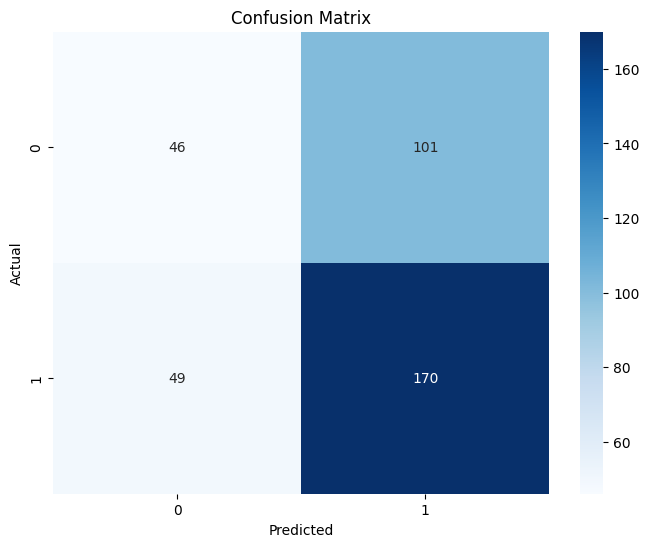

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from MFDFA import MFDFA
from MFDFA import fgn

# Step 1: Extract Features and Labels for Second Participant
participant_id = list(dataset.participant_data.keys())[1]  # Assuming the second participant
participant_data = dataset.participant_data[participant_id]

features, labels = [], []
for signal, fractal, label in zip(participant_data['signals'], participant_data['features'], participant_data['labels']):
    flattened_feature = fractal.flatten().numpy()
    
    features.append(flattened_feature)
    lag = np.unique(np.logspace(0.5, 3, 100).astype(int))
    q_list = np.linspace(-10, 10, 41)
    q_list = q_list[q_list != 0.0]
    lag, dfa = MFDFA(signal.flatten().numpy(), lag=lag, q=q_list, order=1)
    slopes_sun = np.polynomial.polynomial.polyfit(np.log(lag)[20:55], np.log(dfa)[20:55], 1)[1] 
    t_sun = q_list * slopes_sun - 1
    hq_sun = np.gradient(t_sun) / np.gradient(q_list)
    f_sun = q_list * hq_sun - t_sun
    # H_hat = np.polyfit(np.log(lag)[4:20], np.log(dfa[4:20]), 1)[0]
    # features.append(t_sun)
    labels.append(label[1])

features = np.array(features)
labels = np.array(labels)
labels = np.where(labels<1,0,1)
# Step 2: Preprocess - Standardize the Features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.3, random_state=42, stratify=labels)

# Step 4: Handle Class Imbalance using SMOTE
# sm = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Step 5: Hyperparameter Tuning for KNN using GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')

# Step 6: Train Classifier with Best Parameters
best_knn = grid_search.best_estimator_

# Step 7: Evaluate the Model
y_pred = best_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Step 8: Plot Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



Training RNN Classifier
Epoch 1/20, Loss: 0.6904
Epoch 2/20, Loss: 0.6829
Epoch 3/20, Loss: 0.6774
Epoch 4/20, Loss: 0.6967
Epoch 5/20, Loss: 0.6801
Epoch 6/20, Loss: 0.6824
Epoch 7/20, Loss: 0.6805
Epoch 8/20, Loss: 0.6794
Epoch 9/20, Loss: 0.6814
Epoch 10/20, Loss: 0.6782
Epoch 11/20, Loss: 0.6796
Epoch 12/20, Loss: 0.6786
Epoch 13/20, Loss: 0.6831
Epoch 14/20, Loss: 0.6810
Epoch 15/20, Loss: 0.6763
Epoch 16/20, Loss: 0.6790
Epoch 17/20, Loss: 0.6815
Epoch 18/20, Loss: 0.6812
Epoch 19/20, Loss: 0.6787
Epoch 20/20, Loss: 0.6783
RNN Accuracy: 0.5410
RNN Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.37      0.39       147
           1       0.61      0.66      0.63       219

    accuracy                           0.54       366
   macro avg       0.51      0.51      0.51       366
weighted avg       0.53      0.54      0.54       366



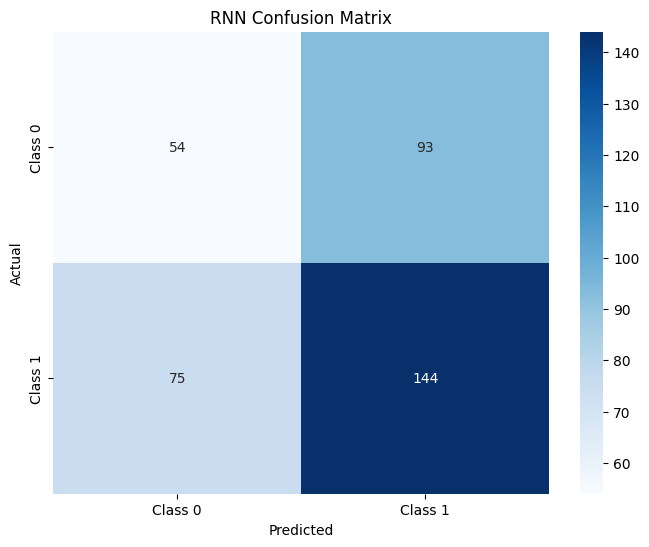

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Extract Features and Labels for Second Participant
participant_id = list(dataset.participant_data.keys())[1]  # Assuming the second participant
participant_data = dataset.participant_data[participant_id]

features, labels = [], []
for signal, fractal, label in zip(participant_data['signals'], participant_data['features'], participant_data['labels']):
    flattened_feature = fractal.flatten().numpy()
    half_feature = flattened_feature[:len(flattened_feature) // 2]  # Extract the first half of features
    features.append(half_feature)
    labels.append(label[1])

features = np.array(features)
labels = np.array(labels)
labels = np.where(labels < 1, 0, 1)

# Step 2: Preprocess - Standardize the Features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.3, random_state=42, stratify=labels)

# Step 4: Apply SMOTE for Class Balancing
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 5: Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Step 6: Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 7: Define RNN Model
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use the last time step
        return out

# Step 8: Initialize Model, Loss, and Optimizer
input_dim = X_train_tensor.shape[1]
model = RNNClassifier(input_dim=input_dim, hidden_dim=64, num_layers=2, num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 9: Train the RNN Model
print("\nTraining RNN Classifier")
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Step 10: Evaluate the RNN Model
model.eval()
y_pred = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())

accuracy = accuracy_score(y_test, y_pred)
print(f'RNN Accuracy: {accuracy:.4f}')
print('RNN Classification Report:')
print(classification_report(y_test, y_pred))

# Step 11: Plot Confusion Matrix for RNN
conf_mat_rnn = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_rnn, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('RNN Confusion Matrix')
plt.show()


Label distribution before resampling:
Class 0: 139
Class 1: 401

Label distribution after SMOTE:
Class 0: 281
Class 1: 281

Training K-Nearest Neighbors Classifier

K-Nearest Neighbors Classifier Results
Training Accuracy: 0.8737
Test Accuracy: 0.5679
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.27      0.40      0.33        42
           1       0.75      0.62      0.68       120

    accuracy                           0.57       162
   macro avg       0.51      0.51      0.50       162
weighted avg       0.63      0.57      0.59       162



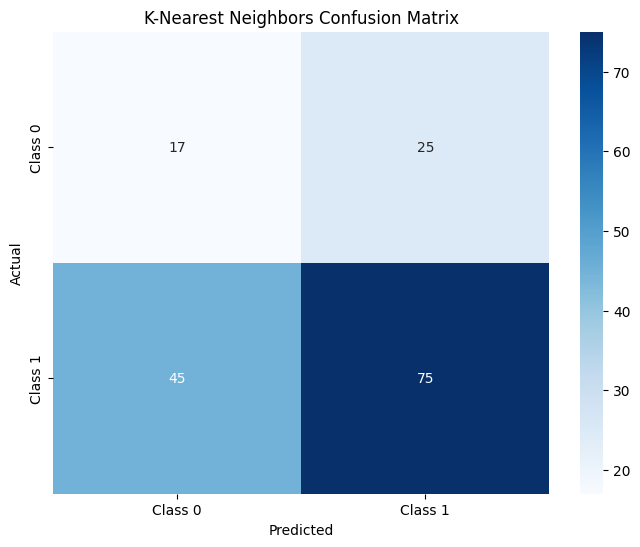

In [71]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Extract Features and Labels for Second Participant
participant_id = list(dataset.participant_data.keys())[2]  # Assuming the second participant
participant_data = dataset.participant_data[participant_id]

features, labels = [], []
for signal, fractal, label in zip(participant_data['signals'], participant_data['features'], participant_data['labels']):
    avg_hq = fractal.mean(axis=1).flatten().numpy()  # Calculate average hq across axis 1 and flatten
    features.append(avg_hq)
    labels.append(label[1])

features = np.array(features).reshape(len(features), -1)  # Ensure features are 2D
labels = np.array(labels)
labels = np.where(labels < 1, 0, 1)

# Print label distribution before resampling
unique, counts = np.unique(labels, return_counts=True)
print("Label distribution before resampling:")
for label, count in zip(unique, counts):
    print(f'Class {label}: {count}')

# Step 2: Preprocess - Standardize the Features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.3, random_state=42, stratify=labels)

# Step 4: Apply SMOTE for Class Balancing
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print label distribution after resampling
unique_resampled, counts_resampled = np.unique(y_train_resampled, return_counts=True)
print("\nLabel distribution after SMOTE:")
for label, count in zip(unique_resampled, counts_resampled):
    print(f'Class {label}: {count}')

# Step 5: Train K-Nearest Neighbors Classifier
print("\nTraining K-Nearest Neighbors Classifier")
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_resampled, y_train_resampled)

# Step 6: Predict using KNN
y_train_pred_knn = knn.predict(X_train_resampled)
y_test_pred_knn = knn.predict(X_test)

# Step 7: Evaluate the KNN Classifier
print("\nK-Nearest Neighbors Classifier Results")
train_accuracy_knn = accuracy_score(y_train_resampled, y_train_pred_knn)
test_accuracy_knn = accuracy_score(y_test, y_test_pred_knn)
print(f'Training Accuracy: {train_accuracy_knn:.4f}')
print(f'Test Accuracy: {test_accuracy_knn:.4f}')

print('Classification Report on Test Set:')
print(classification_report(y_test, y_test_pred_knn))

# Step 8: Plot Confusion Matrix for KNN
conf_mat_knn = confusion_matrix(y_test, y_test_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('K-Nearest Neighbors Confusion Matrix')
plt.show()


In [105]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Step 1: Extract Features and Labels from All Participants
features, labels, participants = [], [], []
expected_dim = 128  # Set the expected dimension for feature vectors

for participant_id in dataset.participant_data.keys():
    participant_data = dataset.participant_data[participant_id]
    for signal, fractal, label in zip(participant_data['signals'], participant_data['features'], participant_data['labels']):
        avg_hq = fractal.mean(axis=1).flatten().numpy()
        pad_length = max(0, expected_dim - avg_hq.shape[0])  # Ensure no negative padding
        avg_hq = np.pad(avg_hq, (0, pad_length), 'constant')
        avg_hq = avg_hq[:expected_dim]  # Trim to expected_dim if necessary
        features.append(avg_hq)
        labels.append(label[1])
        participants.append(participant_id)

features = np.array(features).reshape(len(features), -1)
labels = np.array(labels)
participants = np.array(participants)

# Encode participants as numerical values
participant_ids = {pid: idx for idx, pid in enumerate(np.unique(participants))}
participant_encoded = np.array([participant_ids[pid] for pid in participants])

# Step 2: Preprocess - Standardize the Features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 3: Train-Test Split with Stratification
X_train, X_test, y_train, y_test, p_train, p_test = train_test_split(
    features_scaled, labels, participant_encoded, test_size=0.3, random_state=42, stratify=labels)

# Step 4: Apply SMOTE for Class Balancing on Training Set
smote = SMOTE(random_state=42, k_neighbors=2)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
resampled_indices = smote.fit_resample(np.arange(len(X_train)).reshape(-1, 1), y_train)[0].flatten()
p_train_resampled = p_train[resampled_indices]

# Step 5: Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
p_train_tensor = torch.tensor(p_train_resampled, dtype=torch.long)
p_test_tensor = torch.tensor(p_test, dtype=torch.long)

# Step 6: Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor, p_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor, p_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 7: Define Self-Attention Model for Each Participant
class ParticipantSelfAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=2):
        super(ParticipantSelfAttentionModel, self).__init__()
        self.self_attention = nn.MultiheadAttention(embed_dim=input_dim, num_heads=num_heads)
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc_final = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension
        attn_output, _ = self.self_attention(x, x, x)
        attn_output = attn_output.squeeze(1)
        hidden = self.relu(self.fc(attn_output))
        return self.fc_final(hidden)

# Initialize models for each participant
input_dim = X_train_tensor.shape[1]
num_classes = len(np.unique(labels))
num_participants = len(participant_ids)

participant_models = {
    pid: ParticipantSelfAttentionModel(input_dim=input_dim, hidden_dim=128, output_dim=num_classes)
    for pid in range(num_participants)
}

# Step 8: Train and Evaluate Models per Participant
epochs = 100
for pid, model in participant_models.items():
    print(f"\nTraining Model for Participant {pid}")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Filter data for the current participant
    participant_mask = p_train_tensor == pid
    participant_train_data = X_train_tensor[participant_mask]
    participant_train_labels = y_train_tensor[participant_mask]
    participant_dataset = TensorDataset(participant_train_data, participant_train_labels)
    participant_loader = DataLoader(participant_dataset, batch_size=32, shuffle=True)

    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in participant_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(participant_loader):.4f}')

    # Evaluation
    model.eval()
    participant_test_mask = p_test_tensor == pid
    participant_test_data = X_test_tensor[participant_test_mask]
    participant_test_labels = y_test_tensor[participant_test_mask]

    if len(participant_test_data) == 0:
        print(f"No test data available for Participant {pid}")
        continue

    with torch.no_grad():
        outputs = model(participant_test_data)
        _, predicted = torch.max(outputs, 1)
        accuracy = accuracy_score(participant_test_labels.numpy(), predicted.numpy())
        print(f'Participant {pid} Test Accuracy: {accuracy:.4f}')
        print('Classification Report:')
        print(classification_report(participant_test_labels.numpy(), predicted.numpy()))



Training Model for Participant 0
Epoch 1/100, Loss: 0.5423
Epoch 2/100, Loss: 0.4686
Epoch 3/100, Loss: 0.4496
Epoch 4/100, Loss: 0.4736
Epoch 5/100, Loss: 0.4501
Epoch 6/100, Loss: 0.4522
Epoch 7/100, Loss: 0.4576
Epoch 8/100, Loss: 0.4447
Epoch 9/100, Loss: 0.4678
Epoch 10/100, Loss: 0.4429
Epoch 11/100, Loss: 0.4696
Epoch 12/100, Loss: 0.4629
Epoch 13/100, Loss: 0.4551
Epoch 14/100, Loss: 0.4785
Epoch 15/100, Loss: 0.4400
Epoch 16/100, Loss: 0.4574
Epoch 17/100, Loss: 0.4401
Epoch 18/100, Loss: 0.4487
Epoch 19/100, Loss: 0.4454
Epoch 20/100, Loss: 0.4478
Epoch 21/100, Loss: 0.4590
Epoch 22/100, Loss: 0.4381
Epoch 23/100, Loss: 0.4469
Epoch 24/100, Loss: 0.4463
Epoch 25/100, Loss: 0.4478
Epoch 26/100, Loss: 0.4487
Epoch 27/100, Loss: 0.4468
Epoch 28/100, Loss: 0.4398
Epoch 29/100, Loss: 0.4527
Epoch 30/100, Loss: 0.4528
Epoch 31/100, Loss: 0.4492
Epoch 32/100, Loss: 0.4634
Epoch 33/100, Loss: 0.4461
Epoch 34/100, Loss: 0.4406
Epoch 35/100, Loss: 0.4489
Epoch 36/100, Loss: 0.4587
Epo

In [106]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Step 1: Extract Features and Labels from All Participants
features, labels, participants = [], [], []
expected_dim = 128  # Set the expected dimension for feature vectors

for participant_id in dataset.participant_data.keys():
    participant_data = dataset.participant_data[participant_id]
    for signal, fractal, label in zip(participant_data['signals'], participant_data['features'], participant_data['labels']):
        avg_hq = fractal.mean(axis=1).flatten().numpy()
        pad_length = max(0, expected_dim - avg_hq.shape[0])  # Ensure no negative padding
        avg_hq = np.pad(avg_hq, (0, pad_length), 'constant')
        avg_hq = avg_hq[:expected_dim]  # Trim to expected_dim if necessary
        features.append(avg_hq)
        labels.append(label[1])
        participants.append(participant_id)

features = np.array(features).reshape(len(features), -1)
labels = np.array(labels)
participants = np.array(participants)

# Encode participants as numerical values
participant_ids = {pid: idx for idx, pid in enumerate(np.unique(participants))}
participant_encoded = np.array([participant_ids[pid] for pid in participants])

# Step 2: Preprocess - Standardize the Features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 3: Train-Test Split with Stratification
X_train, X_test, y_train, y_test, p_train, p_test = train_test_split(
    features_scaled, labels, participant_encoded, test_size=0.3, random_state=42, stratify=labels)

# Step 4: Initialize models for each participant
input_dim = X_train.shape[1]
num_classes = len(np.unique(labels))
num_participants = len(participant_ids)

participant_models = {
    pid: ParticipantSelfAttentionModel(input_dim=input_dim, hidden_dim=128, output_dim=num_classes)
    for pid in range(num_participants)
}

# Step 5: Train and Evaluate Models per Participant
epochs = 20
for pid, model in participant_models.items():
    print(f"\nTraining Model for Participant {pid}")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Filter data for the current participant
    participant_mask = p_train == pid
    participant_train_data = X_train[participant_mask]
    participant_train_labels = y_train[participant_mask]

    # Convert to tensors
    X_tensor = torch.tensor(participant_train_data, dtype=torch.float32)
    y_tensor = torch.tensor(participant_train_labels, dtype=torch.long)

    # Create DataLoader
    participant_dataset = TensorDataset(X_tensor, y_tensor)
    participant_loader = DataLoader(participant_dataset, batch_size=32, shuffle=True)

    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in participant_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(participant_loader):.4f}')

    # Evaluation
    model.eval()
    participant_test_mask = p_test == pid
    participant_test_data = torch.tensor(X_test[participant_test_mask], dtype=torch.float32)
    participant_test_labels = torch.tensor(y_test[participant_test_mask], dtype=torch.long)

    if len(participant_test_data) == 0:
        print(f"No test data available for Participant {pid}")
        continue

    with torch.no_grad():
        outputs = model(participant_test_data)
        _, predicted = torch.max(outputs, 1)
        accuracy = accuracy_score(participant_test_labels.numpy(), predicted.numpy())
        print(f'Participant {pid} Test Accuracy: {accuracy:.4f}')
        print('Classification Report:')
        print(classification_report(participant_test_labels.numpy(), predicted.numpy()))

# Define the ParticipantSelfAttentionModel class
class ParticipantSelfAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=2):
        super(ParticipantSelfAttentionModel, self).__init__()
        self.self_attention = nn.MultiheadAttention(embed_dim=input_dim, num_heads=num_heads)
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc_final = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension
        attn_output, _ = self.self_attention(x, x, x)
        attn_output = attn_output.squeeze(1)
        hidden = self.relu(self.fc(attn_output))
        return self.fc_final(hidden)



Training Model for Participant 0
Epoch 1/20, Loss: 0.5421
Epoch 2/20, Loss: 0.5144
Epoch 3/20, Loss: 0.5008
Epoch 4/20, Loss: 0.4678
Epoch 5/20, Loss: 0.4766
Epoch 6/20, Loss: 0.4777
Epoch 7/20, Loss: 0.4639
Epoch 8/20, Loss: 0.4752
Epoch 9/20, Loss: 0.4631
Epoch 10/20, Loss: 0.4549
Epoch 11/20, Loss: 0.4728
Epoch 12/20, Loss: 0.4676
Epoch 13/20, Loss: 0.4687
Epoch 14/20, Loss: 0.4640
Epoch 15/20, Loss: 0.4696
Epoch 16/20, Loss: 0.4656
Epoch 17/20, Loss: 0.4782
Epoch 18/20, Loss: 0.4608
Epoch 19/20, Loss: 0.4591
Epoch 20/20, Loss: 0.4623
Participant 0 Test Accuracy: 0.8261
Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.90       190
           1       0.00      0.00      0.00        40

    accuracy                           0.83       230
   macro avg       0.41      0.50      0.45       230
weighted avg       0.68      0.83      0.75       230


Training Model for Participant 1
Epoch 1/20, Loss: 0.6107
Epoch 2/20

In [127]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

dataset = MatFileDataset("/Users/athenasaghi/VSProjects/CognitiveFatigueDetection/Prediction/window50/", feature_selection='D')

participant_id = list(dataset.participant_data.keys())[1]  # Assuming the second participant
participant_data = dataset.participant_data[participant_id]

features, labels = [], []
for signal, fractal, label in zip(participant_data['signals'], participant_data['features'], participant_data['labels']):
    # flattened_feature = fractal.flatten().numpy()
    fd  = fractal[0][10]
    features.append(fd)
    labels.append(label[1])

tensor([-0.5956, -0.5956, -0.5956, -0.5956, -0.5956, -0.5956, -0.5956, -0.5956,
        -0.5956, -0.5956, -0.5956, -0.5956, -0.5956, -0.5956, -0.5956, -0.5956,
        -0.5956, -0.5956, -0.5956, -0.5956, -0.5956, -0.5956, -0.5956, -0.5956,
        -0.5956, -0.5956, -0.5956, -0.5956, -0.5956, -0.5956, -0.5956, -0.5956,
        -0.5956, -0.5956, -0.5956, -0.5956, -0.5956, -0.5956, -0.5956, -0.5956,
        -0.5956])